In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
#Importing required libraries
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from textblob import Word

import wordcloud
from wordcloud import WordCloud

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


In [3]:
from keras_preprocessing.sequence import pad_sequences

In [4]:
import pandas as pd
import time
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',300)

from nltk.corpus import stopwords
import re
import nltk
from nltk import tokenize
from nltk.stem import WordNetLemmatizer

import math

import spacy
import os

csvs = os.listdir("/kaggle/input/hotel-reviews")

In [5]:
# TODO: modify these list if needed (eg. if you want to load only 1 csv from star3, delete other csvs in star3 list)
star3 = ['cleaned_ibis-sg-bencoolen.csv','cleaned_hotel-boss.csv','cleaned_hotel-G.csv',
           'cleaned_village-hotel-albert-court-by-far-east-hospitality.csv',
           'cleaned_holiday-inn-express-clarke-quay.csv']
star4 = ['cleaned_village-hotel-changi-by-far-east-hospitality.csv',
         'cleaned_park-regis.csv', 'cleaned_grand-mercure-sg-roxy.csv',
         'cleaned_paradox-sg-merchant-court.csv','cleaned_crowne-plaza.csv']
star5 = ['cleaned_fullerton.csv', 'cleaned_parkroyal-collection-marina-bay.csv', 'cleaned_pan-pacific.csv',
          'cleaned_mbs_total.csv', 'cleaned_swissotel-the-stamford.csv']
ROOT = ''
RAW_FOLDER = "/kaggle/input/hotel-reviews"
def filter_date(row):
      try:
        #print(int(row["date_of_stay"][-4:]))
        return int(row["date_of_stay"][-4:])
      except:
        #print("2000")
        return 2000
def combine_csv_to_dataframe(file_names, all_star = False, filterDate = True):
    """
    Combine multiple CSV files into a single DataFrame.

    Parameters:
    file_names (list): List of CSV file names. 
    all_star (bool): whether or not to load all the hotels (False if only want to load 1 type of hotel star). 
    filterData (bool): whether or not to remove all data dated before 2015

    Returns:
    pd.DataFrame: Combined DataFrame.
    """
    combined_df = pd.DataFrame()

    for file_name in file_names:
        file_name = RAW_FOLDER + "/" + file_name
        try:
            df = pd.read_csv(file_name)
            if all_star:
                if file_name in star3:
                    df["star"] = 3
                elif file_name in star4:
                    df["star"] = 4
                else:
                    df["star"] = 5
            print(f"Length of {file_name} is {len(df)}")
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"Empty or invalid CSV file: {file_name}")
    combined_df["year"] = combined_df.apply(lambda row: filter_date(row), axis = 1)
    if filterDate:
        combined_df = combined_df[combined_df["year"]>=2015]
    return combined_df

In [78]:
df = combine_csv_to_dataframe(star3, all_star = False, filterDate = False)

Length of /kaggle/input/hotel-reviews/cleaned_ibis-sg-bencoolen.csv is 2217
Length of /kaggle/input/hotel-reviews/cleaned_hotel-boss.csv is 3568
Length of /kaggle/input/hotel-reviews/cleaned_hotel-G.csv is 3826
Length of /kaggle/input/hotel-reviews/cleaned_village-hotel-albert-court-by-far-east-hospitality.csv is 2290
Length of /kaggle/input/hotel-reviews/cleaned_holiday-inn-express-clarke-quay.csv is 2169


In [79]:
df.dropna(subset=['label'], inplace=True)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14069 entries, 0 to 14069
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             14069 non-null  int64  
 1   traveller_username                     14069 non-null  object 
 2   review_title                           14067 non-null  object 
 3   review_text                            14069 non-null  object 
 4   travel_type                            4634 non-null   object 
 5   traveller_country_origin               9921 non-null   object 
 6   traveller_total_contributions          14040 non-null  object 
 7   traveller_total_helpful_contributions  9934 non-null   float64
 8   rating                                 14069 non-null  float64
 9   valid_rating                           14069 non-null  bool   
 10  label                                  14069 non-null  object 
 11  cleaned

In [81]:
df.label.value_counts()

label
Positive    11266
Neutral      1745
Negative     1058
Name: count, dtype: int64

In [82]:
min(df.label.value_counts())

1058

In [83]:
df = df[df["label"]!="Neutral"]

In [84]:
import random

In [85]:
def encode_label(row):
    if row["label"] == "Positive":
        return 1
    else:
        return 0

In [86]:
def split_dataset(df, test_size, random_state):

    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    return df_train, df_test

In [87]:
df["label"] = df.apply(lambda row: encode_label(row), axis = 1)

In [88]:
train, test = split_dataset(df, test_size=0.2, random_state=0) # positive labels being encoded as 1

In [89]:
train.label.value_counts()

label
1    9021
0     838
Name: count, dtype: int64

In [90]:
df = train

In [91]:
def undersampling(df, label):
    no_samples = min(df.label.value_counts())
    df0 = df[df[label]==0].sample(n=no_samples, random_state=1)
    df1 = df[df[label]==1].sample(n=no_samples, random_state=1)
    #df2 = df[df[label]==2].sample(n=no_samples, random_state=1)
    return pd.concat([df0, df1])

In [92]:
undersampled = undersampling(df, 'label')

In [93]:
undersampled.label.value_counts()

label
0    838
1    838
Name: count, dtype: int64

In [94]:
from transformers import BertTokenizer, TFBertForSequenceClassification, InputExample, InputFeatures


model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [96]:
#cw = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=np.array(train.textblob_sentiment))

In [97]:
#cw

In [98]:
#class_weight = {}

In [99]:
#for i in range(len(list(cw))):
#  class_weight[i]=cw[i]
#class_weight

In [100]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, #Globally unique ID for bookkeeping, unused in this case
                                                           text_a=x[DATA_COLUMN],
                                                           text_b=None,
                                                           label=x[LABEL_COLUMN]), axis=1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                               text_a=x[DATA_COLUMN],
                                                               text_b=None,
                                                               label=x[LABEL_COLUMN]), axis=1)
  
    return train_InputExamples, validation_InputExamples

#train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, 'lem_review', 'label')
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )




In [101]:
DATA_COLUMN = 'lem_review'
LABEL_COLUMN = 'label'

In [102]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

In [104]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)

In [105]:
train_data = train_data.shuffle(100).batch(32)
#.repeat(2)
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

In [ ]:
'''
val_accs = {}
for lr in [0.001, 1e-4, 1e-5]:
  for eps in [1e-6, 1e-7, 1e-8]:
    for cn in [1e-3, 1e-2, 1]:
        model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=3)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-6, clipnorm=1.0), #lr = 3e-5, eps = 01e-8
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy('val_accuracy')])

        history = model.fit(train_data, epochs=2, validation_data=validation_data, class_weight = class_weight)
        val_accs[(lr, eps, cn)] = history
'''

In [106]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sc_accuracy', patience=2, restore_best_weights=True)

In [107]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-8, clipnorm=1.0), #lr=3e-5, eps=01e-8
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('sc_accuracy')]
)

history = model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data,
    callbacks=[callback],
    #class_weight=class_weight
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
309/309 [==============================] - 328s 896ms/step - loss: 0.1378 - sc_accuracy: 0.9506 - val_loss: 0.0772 - val_sc_accuracy: 0.9712
Epoch 2/5
309/309 [==============================] - 268s 868ms/step - loss: 0.0588 - sc_accuracy: 0.9817 - val_loss: 0.0904 - val_sc_accuracy: 0.9716
Epoch 3/5
309/309 [==============================] - 267s 864ms/step - loss: 0.0324 - sc_accuracy: 0.9887 - val_loss: 0.0933 - val_sc_accuracy: 0.9732
Epoch 4/5
309/309 [==============================] - 266s 862ms/step - loss: 0.0195 - sc_accuracy: 0.9944 - val_loss: 0.1285 - val_sc_accuracy: 0.9728
Epoch 5/5
309/309 [==============================] - 266s 861ms/step - loss: 0.0120 - sc_accuracy: 0.9959 - val_loss: 0.0784 - val_sc_accuracy: 0.9736


In [ ]:
#import os
#saved_model = "textblob_saved_model_booking3"
#os.makedirs(saved_model, exist_ok=True)
#model.save(saved_model)

In [117]:
test_set = test

#test_set = test_set[test_set["label"]!="neutral"]

#test_set=test_set.replace({"label": {'positive':1, 'negative':0}})

In [118]:
#from google.colab import files
#files.download('textblob_saved_model.zip') 

In [119]:
pred_sentences = ['Cool',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']

In [120]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
      print(pred_sentences[i], ": \n", label[i])

Cool : 
 1
One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie : 
 0


In [121]:
def convert_data_to_examples(data, DATA_COLUMN, LABEL_COLUMN): 

  data_InputExamples = data.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                         text_a=x[DATA_COLUMN],
                                                         text_b=None,
                                                         label=x[LABEL_COLUMN]), axis=1)
  
  return data_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

In [122]:
DATA_COLUMN = 'lem_review'
LABEL_COLUMN = 'label'

In [123]:
#X_test = list(test_data.total_review)
y_test = list(test_set.label)

In [124]:
test_InputExamples = convert_data_to_examples(test_set, DATA_COLUMN, LABEL_COLUMN)

In [125]:
test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

In [126]:
preds = model.predict(test_data)

78/78 [==============================] - 26s 271ms/step


In [127]:
preds.logits

array([[-4.290108  ,  5.0183053 ],
       [ 1.6917638 , -2.811709  ],
       [-3.9198232 ,  4.244393  ],
       ...,
       [-3.6839182 ,  4.065287  ],
       [-1.5210677 ,  0.87264025],
       [-3.551209  ,  4.739506  ]], dtype=float32)

In [128]:
label = tf.argmax(preds.logits, axis=1)
label = label.numpy()

In [129]:
label

array([1, 0, 1, ..., 1, 1, 1])

In [130]:
sklearn.metrics.confusion_matrix(label, y_test)

array([[ 196,   41],
       [  24, 2204]])

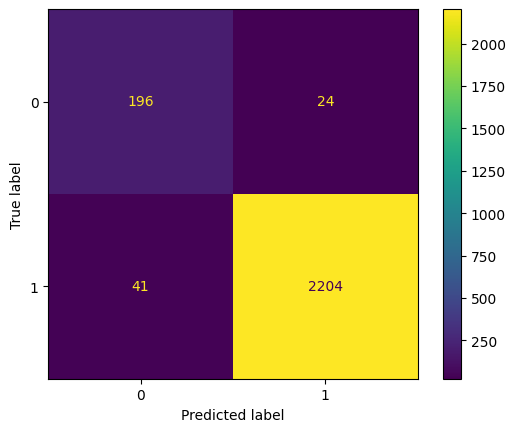

In [131]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, label)

In [132]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, label)

0.973630831643002